# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
# Ваш код

batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="postnauka_batches", 
                                        batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем

# Ваш код
model_artm = artm.ARTM(num_topics=T, 
                       topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"], 
                       class_ids={"text":1 , "author":1}, 
                       num_document_passes=1, 
                       reuse_theta=True, 
                       cache_theta=True, 
                       seed=-1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
# Ваш код
np.random.seed(1)

dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
# Ваш код

model_artm.scores.add(artm.TopTokensScore(name="score_text", num_tokens=15, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name="score_author", num_tokens=15, class_id='author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Reg', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=['text'], 
                                                            topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installe

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='NewReg', 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=['text'], 
                                                            topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [12]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installe

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [18]:
# Ваш код
key_words = []
for topic_name in model_artm.topic_names:
    print topic_name + ': '
    tokens = model_artm.score_tracker["score_text"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    key_words.append(word)
    print

sbj0: 
власть церковь средневековый император совершать русь римский святой александр папа вера князь король сага знаменитый
sbj1: 
земля планета вокруг атмосфера солнце образовываться внутренний белый солнечный газ вода карлик спутник поверхность орбита
sbj2: 
система движение поведение двигаться трудность частота придумывать точность испытывать цикл искусственный час участник положительный относительность
sbj3: 
культура понятие культурный опыт восприятие сознание формироваться личность феномен воспринимать ощущение логика чувство михаил предмет
sbj4: 
право искусство литературный литература юрист произведение юридический писатель должник собственность обязательство владение требование римский исполнение
sbj5: 
материал структура свойство молекула применение электронный углерод поверхность полимер кристалл использование трехмерный алмаз твердый углеродный
sbj6: 
книга тема фильм автор статья написать литература посвящать кино опубликовывать документ журнал жанр театр академия
sbj7: 


In [19]:
for topic_name in model_artm.topic_names:
    print topic_name + ': '
    tokens = model_artm.score_tracker["score_author"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0: 
Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Игорь_Данилевский Алексей_Юдин Елена_Уханова Ольга_Брилева Владимир_Петрухин Григорий_Бондаренко Елена_Браун Екатерина_Болтунова Ольга_Тогоева Дмитрий_Полдников Олег_Воскобойников
sbj1: 
Сергей_Попов Кирилл_Еськов Дмитрий_Титов Валерий_Сулейманов Зоригто_Намсараев Николай_Дронин Сергей_Наугольных Александр_Марков Роман_Рафиков Александр_Слободкин Елизавета_Ривкина Наталья_Новикова Сергей_Писарев Дмитрий_Вибе Юлия_Краус
sbj2: 
Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Эмиль_Ахмедов Михаил_Фейгельман Антон_Суворов Даниэль_Сельва Виталий_Пальчиков Василий_Климов Илья_Щуров Татьяна_Клячко Юджин_Ползик Алексей_Желтиков Сергей_Кулик
sbj3: 
Виталий_Куренной Михаил_Соколов Пётр_Турчин Алексей_Руткевич Владимир_Миронов Сергей_Арутюнов Кирилл_Разлогов Татьяна_Смоктунович Александр_Доброхотов Александр_Гофман Андрей_Лосев Павел_Степанцов Александр_Кислов Фёдор_Гиренок Дмитрий_Иванов
sbj4: 
Дмитри

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [20]:
sbj_topic_labels = key_words   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [22]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])
print(theta.shape)
print(phi_a.shape)

(30, 1728)
(539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\ProgramData\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


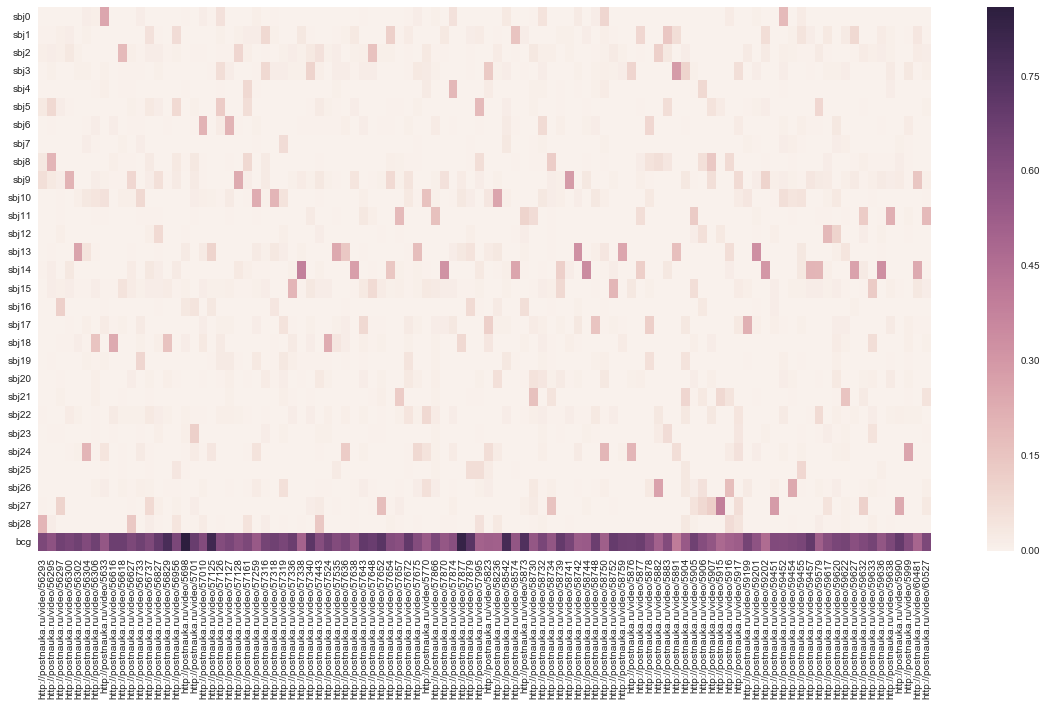

In [23]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta[theta.columns[:100]])
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [24]:
# Ваш код
pt = pd.DataFrame({'pt': (theta.sum(axis=1) / theta.sum(axis=1).sum()).as_matrix()} , index=topic_labels[:-1])
print(pt.sort_values(by='pt'))

                       pt
столыпин         0.003806
индеец           0.004842
диктатура        0.005404
травма           0.008418
общественный     0.008495
шимпанзе         0.008524
академия         0.009395
исполнение       0.009549
синтаксический   0.009960
реализовать      0.009990
железо           0.010073
диагностика      0.010207
относительность  0.011361
углеродный       0.011398
медиа            0.012089
знаменитый       0.013161
орбита           0.013934
виктор           0.014763
устойчивый       0.015102
процедура        0.015181
восточный        0.015384
душа             0.016446
предмет          0.017256
военный          0.018289
следующий        0.019092
идеология        0.021037
телескоп         0.022297
бактерия         0.027446
эксперимент      0.028220
один             0.608881


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

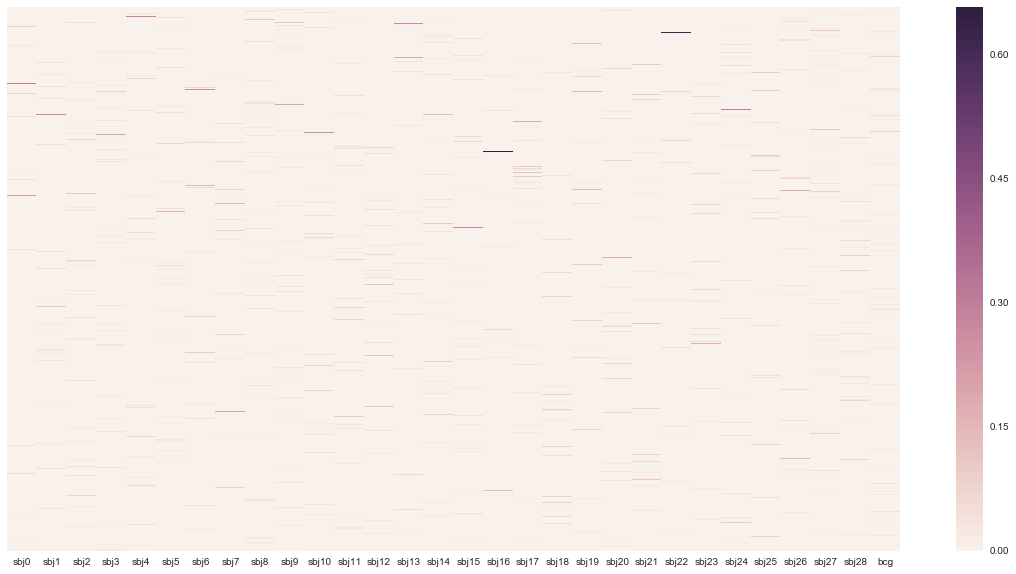

In [25]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [26]:
a_cnts = phi_a[phi_a > 0.01].dropna(how='all').count(axis=1, numeric_only=True)
print(a_cnts.sort_values())

Сергей_Демокритов             1
Питер_Лэнсдорп                1
Джеральд_де_Хаан              1
Дмитрий_Сорокин               1
Дмитрий_Арзютов               1
Сергей_Троицкий               1
Уолтер_Льюин                  1
Кирилл_Соловьев               1
Петр_Резвых                   1
Александр_Сафонов             1
Алексей_Расторгуев            1
Александр_Слободкин           1
Деметрис_Зейналипур           1
Александр_Баландин            1
Джефф_Лихтман                 1
Ирина_Бёме                    1
Ян_Левченко                   1
Николай_Мощевитин             1
Елизавета_Ривкина             1
Анна_Соколова                 1
Светлана_Баньковская          1
Махзарин_Банаджи              1
Андрей_Лосев                  1
Елизавета_Бонч-Осмоловская    1
Варвара_Веденина              1
Александр_Жданов              1
Дмитрий_Казанцев              1
Филипп_Хайтович               1
Андрей_Летаров                1
Рудольф_Йениш                 1
                             ..
Мария_Ма

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [27]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [28]:
# Ваш код
pta = np.zeros(phi_a.shape)
total = 0
for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        total += phi_a.iloc[i,j] * pt.iloc[j]
for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        pta[i,j] = (phi_a.iloc[i,j] * pt.iloc[j]) / total
        
model = MDS(dissimilarity="precomputed", n_components=2)
model.fit(pairwise_distances(pta, metric='cosine'))

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=None, verbose=0)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

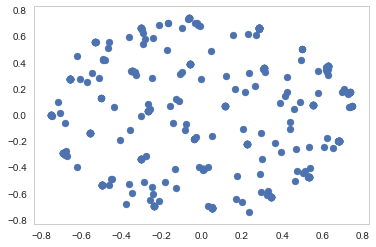

In [29]:
# Ваш код
plt.scatter(model.embedding_[:,0],model.embedding_[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

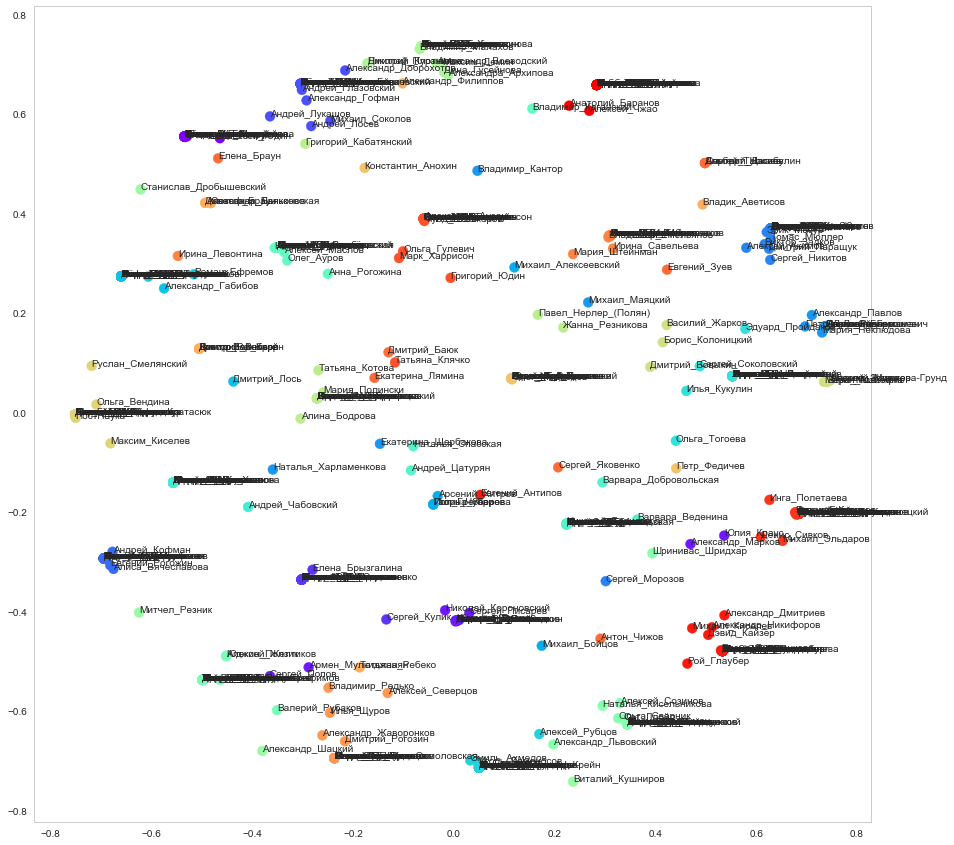

In [30]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код

plt.figure(figsize=(15, 15))
plt.scatter(model.embedding_[:,0],model.embedding_[:,1], c=colors[np.argmax(pta, axis=1)] , s = 100)
for i in range(model.embedding_.shape[0]):
    plt.annotate(phi_a.index[i], (model.embedding_[i,0], model.embedding_[i,1]))
    
plt.savefig('postnauka.pdf', format='pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [31]:
# Ваш код
doc = theta / np.sum(theta)
doc_ind = (np.array(doc)).argsort(axis = 1)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [32]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [33]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [34]:
# Ваш код
for i in range(len(model_artm.topic_names)):
    topic_name = model_artm.topic_names[i]
    display(HTML("<h1>" + topic_labels[i] + "</h1>"))
    tokens = model_artm.score_tracker["score_text"].last_tokens
    for j in range(0,10):
        display(HTML('<font color="green">' + tokens[topic_name][j] + '</font>'))
    for k in range(1,11):
        print(doc.columns[doc_ind[i][-k]])

http://postnauka.ru/video/3348
http://postnauka.ru/video/24030
http://postnauka.ru/video/23472
http://postnauka.ru/video/9299
http://postnauka.ru/video/9968
http://postnauka.ru/video/31677
http://postnauka.ru/video/50350
http://postnauka.ru/video/42999
http://postnauka.ru/video/50668
http://postnauka.ru/video/42996


http://postnauka.ru/video/53693
http://postnauka.ru/video/9690
http://postnauka.ru/video/31695
http://postnauka.ru/video/32889
http://postnauka.ru/video/9835
http://postnauka.ru/video/51364
http://postnauka.ru/video/36249
http://postnauka.ru/video/49261
http://postnauka.ru/video/37994
http://postnauka.ru/video/24245


http://postnauka.ru/video/1856
http://postnauka.ru/video/51174
http://postnauka.ru/video/52548
http://postnauka.ru/video/52553
http://postnauka.ru/video/56618
http://postnauka.ru/video/34426
http://postnauka.ru/video/19509
http://postnauka.ru/video/21662
http://postnauka.ru/video/37982
http://postnauka.ru/video/51382


http://postnauka.ru/video/11034
http://postnauka.ru/video/7169
http://postnauka.ru/video/5891
http://postnauka.ru/video/12740
http://postnauka.ru/video/12524
http://postnauka.ru/video/36707
http://postnauka.ru/video/7747
http://postnauka.ru/video/20388
http://postnauka.ru/video/5180
http://postnauka.ru/video/8623


http://postnauka.ru/video/17913
http://postnauka.ru/video/38009
http://postnauka.ru/video/31688
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/16822
http://postnauka.ru/video/17825
http://postnauka.ru/video/14297
http://postnauka.ru/video/36715
http://postnauka.ru/video/39998


http://postnauka.ru/video/13544
http://postnauka.ru/video/31182
http://postnauka.ru/video/41686
http://postnauka.ru/video/22592
http://postnauka.ru/video/46379
http://postnauka.ru/video/36492
http://postnauka.ru/video/36490
http://postnauka.ru/video/47818
http://postnauka.ru/video/36657
http://postnauka.ru/video/36655


http://postnauka.ru/video/10759
http://postnauka.ru/video/39723
http://postnauka.ru/video/13541
http://postnauka.ru/video/47204
http://postnauka.ru/video/38510
http://postnauka.ru/video/47202
http://postnauka.ru/video/47208
http://postnauka.ru/video/57010
http://postnauka.ru/video/42807
http://postnauka.ru/video/57127


http://postnauka.ru/video/1893
http://postnauka.ru/video/48480
http://postnauka.ru/video/32882
http://postnauka.ru/video/37992
http://postnauka.ru/video/50656
http://postnauka.ru/video/51331
http://postnauka.ru/video/1899
http://postnauka.ru/video/21660
http://postnauka.ru/video/27967
http://postnauka.ru/video/48335


http://postnauka.ru/video/18048
http://postnauka.ru/video/11646
http://postnauka.ru/video/19071
http://postnauka.ru/video/51490
http://postnauka.ru/video/8953
http://postnauka.ru/video/24449
http://postnauka.ru/video/23253
http://postnauka.ru/video/48107
http://postnauka.ru/video/19086
http://postnauka.ru/video/11630


http://postnauka.ru/video/13043
http://postnauka.ru/video/18873
http://postnauka.ru/video/18870
http://postnauka.ru/video/14283
http://postnauka.ru/video/22760
http://postnauka.ru/video/11651
http://postnauka.ru/video/47950
http://postnauka.ru/video/2945
http://postnauka.ru/video/24434
http://postnauka.ru/video/47952


http://postnauka.ru/video/31183
http://postnauka.ru/video/35041
http://postnauka.ru/video/46939
http://postnauka.ru/video/19574
http://postnauka.ru/video/51180
http://postnauka.ru/video/41895
http://postnauka.ru/video/25906
http://postnauka.ru/video/29992
http://postnauka.ru/video/42809
http://postnauka.ru/video/26667


http://postnauka.ru/video/22892
http://postnauka.ru/video/59638
http://postnauka.ru/video/18613
http://postnauka.ru/video/30678
http://postnauka.ru/video/22883
http://postnauka.ru/video/60527
http://postnauka.ru/video/57657
http://postnauka.ru/video/30606
http://postnauka.ru/video/40266
http://postnauka.ru/video/6377


http://postnauka.ru/video/46562
http://postnauka.ru/video/23172
http://postnauka.ru/video/33793
http://postnauka.ru/video/51169
http://postnauka.ru/video/13746
http://postnauka.ru/video/51501
http://postnauka.ru/video/59617
http://postnauka.ru/video/25321
http://postnauka.ru/video/12156
http://postnauka.ru/video/40277


http://postnauka.ru/video/53171
http://postnauka.ru/video/50071
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/58742
http://postnauka.ru/video/50066
http://postnauka.ru/video/48959
http://postnauka.ru/video/49203
http://postnauka.ru/video/10751
http://postnauka.ru/video/46313


http://postnauka.ru/video/6673
http://postnauka.ru/video/31193
http://postnauka.ru/video/17780
http://postnauka.ru/video/57338
http://postnauka.ru/video/29998
http://postnauka.ru/video/7067
http://postnauka.ru/video/2971
http://postnauka.ru/video/30015
http://postnauka.ru/video/23506
http://postnauka.ru/video/23502


http://postnauka.ru/video/24182
http://postnauka.ru/video/24451
http://postnauka.ru/video/23763
http://postnauka.ru/video/19577
http://postnauka.ru/video/5181
http://postnauka.ru/video/53415
http://postnauka.ru/video/56052
http://postnauka.ru/video/17421
http://postnauka.ru/video/57336
http://postnauka.ru/video/46933


http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/42707
http://postnauka.ru/video/42735
http://postnauka.ru/video/37732
http://postnauka.ru/video/49262
http://postnauka.ru/video/35150
http://postnauka.ru/video/40880
http://postnauka.ru/video/36253
http://postnauka.ru/video/17397


http://postnauka.ru/video/12738
http://postnauka.ru/video/32906
http://postnauka.ru/video/2526
http://postnauka.ru/video/53044
http://postnauka.ru/video/12371
http://postnauka.ru/video/3418
http://postnauka.ru/video/9860
http://postnauka.ru/video/31690
http://postnauka.ru/video/37965
http://postnauka.ru/video/26234


http://postnauka.ru/video/6720
http://postnauka.ru/video/36272
http://postnauka.ru/video/47548
http://postnauka.ru/video/30017
http://postnauka.ru/video/56616
http://postnauka.ru/video/46559
http://postnauka.ru/video/48960
http://postnauka.ru/video/2946
http://postnauka.ru/video/57524
http://postnauka.ru/video/51499


http://postnauka.ru/video/5396
http://postnauka.ru/video/48492
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/45548
http://postnauka.ru/video/28944
http://postnauka.ru/video/22079
http://postnauka.ru/video/54742
http://postnauka.ru/video/48621
http://postnauka.ru/video/55533


http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/47301
http://postnauka.ru/video/9998
http://postnauka.ru/video/17604
http://postnauka.ru/video/7068
http://postnauka.ru/video/29812
http://postnauka.ru/video/30026
http://postnauka.ru/video/32900


http://postnauka.ru/video/2541
http://postnauka.ru/video/54325
http://postnauka.ru/video/51384
http://postnauka.ru/video/27925
http://postnauka.ru/video/55539
http://postnauka.ru/video/43853
http://postnauka.ru/video/13746
http://postnauka.ru/video/44263
http://postnauka.ru/video/12974
http://postnauka.ru/video/49206


http://postnauka.ru/video/12083
http://postnauka.ru/video/3628
http://postnauka.ru/video/10783
http://postnauka.ru/video/434
http://postnauka.ru/video/11640
http://postnauka.ru/video/17492
http://postnauka.ru/video/17491
http://postnauka.ru/video/23361
http://postnauka.ru/video/6380
http://postnauka.ru/video/2530


http://postnauka.ru/video/2531
http://postnauka.ru/video/52738
http://postnauka.ru/video/31671
http://postnauka.ru/video/2947
http://postnauka.ru/video/34964
http://postnauka.ru/video/42416
http://postnauka.ru/video/3635
http://postnauka.ru/video/49437
http://postnauka.ru/video/3420
http://postnauka.ru/video/37976


http://postnauka.ru/video/10779
http://postnauka.ru/video/9429
http://postnauka.ru/video/12527
http://postnauka.ru/video/21631
http://postnauka.ru/video/43664
http://postnauka.ru/video/9997
http://postnauka.ru/video/47300
http://postnauka.ru/video/5999
http://postnauka.ru/video/7065
http://postnauka.ru/video/7785


http://postnauka.ru/video/12375
http://postnauka.ru/video/48114
http://postnauka.ru/video/51171
http://postnauka.ru/video/15341
http://postnauka.ru/video/47550
http://postnauka.ru/video/40001
http://postnauka.ru/video/24461
http://postnauka.ru/video/35038
http://postnauka.ru/video/46341
http://postnauka.ru/video/8964


http://postnauka.ru/video/31684
http://postnauka.ru/video/9389
http://postnauka.ru/video/7781
http://postnauka.ru/video/30601
http://postnauka.ru/video/3605
http://postnauka.ru/video/28282
http://postnauka.ru/video/5882
http://postnauka.ru/video/6497
http://postnauka.ru/video/13152
http://postnauka.ru/video/56290


http://postnauka.ru/video/19436
http://postnauka.ru/video/10475
http://postnauka.ru/video/5915
http://postnauka.ru/video/10754
http://postnauka.ru/video/17051
http://postnauka.ru/video/5390
http://postnauka.ru/video/9854
http://postnauka.ru/video/35051
http://postnauka.ru/video/44252
http://postnauka.ru/video/6477


http://postnauka.ru/video/2973
http://postnauka.ru/video/50340
http://postnauka.ru/video/22314
http://postnauka.ru/video/31198
http://postnauka.ru/video/18408
http://postnauka.ru/video/50699
http://postnauka.ru/video/56293
http://postnauka.ru/video/21125
http://postnauka.ru/video/27835
http://postnauka.ru/video/24473


http://postnauka.ru/video/13041
http://postnauka.ru/video/21276
http://postnauka.ru/video/3403
http://postnauka.ru/video/2957
http://postnauka.ru/video/18006
http://postnauka.ru/video/7525
http://postnauka.ru/video/55540
http://postnauka.ru/video/17415
http://postnauka.ru/video/44745
http://postnauka.ru/video/16157


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 